# Build convrnn

So we've downloaded the dataset and analyzed and visualized it. We're ready now for the next step: building the convrnn.

We first test it with a synthetic dataset: a ball that bounces.

In [1]:
#!conda install pytorch torchvision -c pytorch
#!conda install scikit-image

from time import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd.variable import Variable

from convlstm_pytorch import ConvLSTM, ConvLSTMCell
from synthetic_datasets import Ball
import utils
from train import train

# Give init parameters here
# b = Ball()
# Calling an instance of Ball generates a batch of images
# utils.plotting.plot_synthetic(b(sequence_length=100)[0])

/home/ubuntu/nowcasting-convrnn/src/utils/plotting.py:5: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/src/anaconda3/envs/main/lib/python3.6/site-pack

I don't know how the lstm functions with its output range. Let's do some experiments to find out.

In [2]:
b = Ball(shape=(10,10), radius=(3,3))
l = ConvLSTMCell(input_size=(10,10), input_dim=1, hidden_dim=1, kernel_size=(1,1), bias=True, use_cuda=False)

# Init weights
# l.conv.weight.data.fill_(0)
# l.conv.weight.data[3,0].fill_(1)
# Bias order: (i,f,o,g) where g = C_candidate

h,c = l.init_hidden(batch_size=1)
# (b,t,c,h,w)
inp = Variable(torch.from_numpy(b(sequence_length=1).astype(np.float32)))[0]
# inp = Variable(torch.ones_like(torch.from_numpy(b(sequence_length=1).astype(np.float32))))[np.newaxis]
# inp = inp * 1

h_o, c_o = l(inp, (h,c))

im = c_o[0].data.numpy()
print("Range   {:.4f}  {:.4f}".format(im.min(), im.max()))

plt.close('all')
utils.plotting.plot_synthetic(im)

Range   0.0000  0.0049


Let's train it on the synthetic Ball dataset.

Batch    0 loss: 1.18270 min 0.47 max 0.48 lr=[0.04] t_gen=0.21s t_fwd=0.84s t_loss=0.30s t_bwd=1.42s b/s=0.36
Batch    1 loss: 1.75687 min 0.12 max 0.86 lr=[0.04] t_gen=0.21s t_fwd=0.28s t_loss=0.30s t_bwd=1.41s b/s=0.45
Batch    2 loss: 1.12353 min 0.13 max 0.79 lr=[0.04] t_gen=0.21s t_fwd=0.28s t_loss=0.30s t_bwd=1.41s b/s=0.45
Batch    3 loss: 0.90535 min 0.18 max 0.64 lr=[0.04] t_gen=0.22s t_fwd=0.28s t_loss=0.30s t_bwd=1.41s b/s=0.45
Caught KeyboardInterrupt, stopping training...


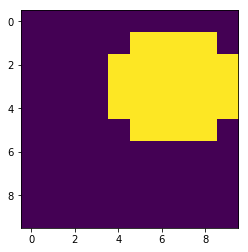

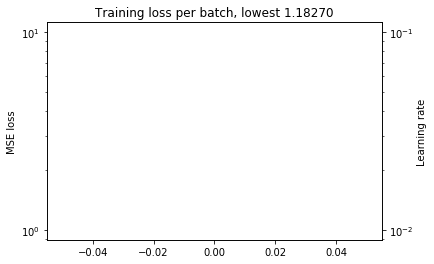

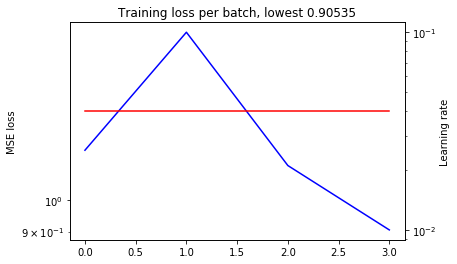

In [3]:
a = {
    "use_cuda": True,
    
    # Ball params
    "input_size": [30,30],
    "radius": [8,8],
    "velocity": 2,
    "gravity": 0,
    "bounce": True,
    
    # Network params
    "input_dim": 1,
    "hidden_dim": [32,16,16],
    "kernel_size": [5,5],
    
    # Meta params
    "learning_rate": 0.04,
    "n_batches": 1200,
    "batch_size": 200,
    "inputs_seq_len": 4,
    "outputs_seq_len": 5,
    
    # Learning rate scheme
    "step_size": 150,
    "gamma": 0.5
}

model, losses, learning_rates = train(a, save_dir="test")


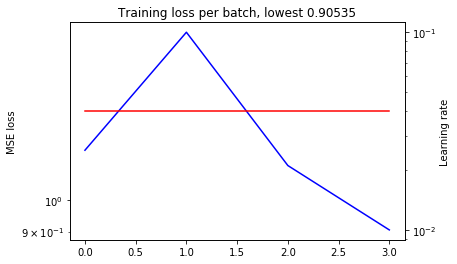

In [4]:
utils.plotting.plot_loss(losses, learning_rates=learning_rates)

In [5]:
b = Ball(shape=a['input_size'], radius=a['radius'], velocity=a['velocity'], gravity=a['gravity'], bounce=a['bounce'])

inputs = b(batch_size=1, sequence_length=4)
inputs_var = Variable(torch.from_numpy(inputs)).cuda()

preds = model(inputs_var, n_targets=15)

inp = [inputs[0,timestep,0] for timestep in range(inputs.shape[1])]
p = [v[0,0].data for v in preds]

utils.plotting.plot_synthetic(inp+p, interval=400)